<a href="https://colab.research.google.com/github/Chandramani05/Hunting-for-Exoplanet-in-Deep-Space/blob/main/MSML_63_SVM%2C_Random_Forest_and_XGBoost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [102]:
import joblib
import numpy as np
import pandas as pd
import matplotlib.cm as cm
import seaborn as sns
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, StratifiedKFold, cross_val_score, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, balanced_accuracy_score, classification_report, cohen_kappa_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from yellowbrick.target import FeatureCorrelation
from yellowbrick.features import rank2d, RadViz, Rank2D
from yellowbrick.classifier import DiscriminationThreshold, PrecisionRecallCurve, ROCAUC
from yellowbrick.model_selection import feature_importances, CVScores, RFECV, FeatureImportances
from yellowbrick.model_selection import LearningCurve, ValidationCurve
from yellowbrick.classifier import ClassificationReport, ClassPredictionError, ConfusionMatrix
from xgboost import XGBClassifier


In [3]:
df = pd.read_csv("/content/drive/MyDrive/Kepler Exoplanet/data/Cleaned Kepler Data.csv")
df.drop(columns = ["Unnamed: 0"], inplace=True)
print(df.shape)
df.head()

(9199, 47)


,rowid,kepid,kepoi_name,koi_disposition,koi_pdisposition,koi_score,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,...,koi_steff_err2,koi_slogg,koi_slogg_err1,koi_slogg_err2,koi_srad,koi_srad_err1,koi_srad_err2,ra,dec,koi_kepmag
0,1,10797460,K00752.01,CONFIRMED,CANDIDATE,1.000,0,0,0,0,...,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
1,2,10797460,K00752.02,CONFIRMED,CANDIDATE,0.969,0,0,0,0,...,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
2,3,10811496,K00753.01,FALSE POSITIVE,FALSE POSITIVE,0.000,0,1,0,0,...,-176.0,4.544,0.044,-0.176,0.868,0.233,-0.078,297.00482,48.134129,15.436
3,4,10848459,K00754.01,FALSE POSITIVE,FALSE POSITIVE,0.000,0,1,0,0,...,-174.0,4.564,0.053,-0.168,0.791,0.201,-0.067,285.53461,48.285210,15.597
4,5,10854555,K00755.01,CONFIRMED,CANDIDATE,1.000,0,0,0,0,...,-211.0,4.438,0.070,-0.210,1.046,0.334,-0.133,288.75488,48.226200,15.509


##Getting the Columns without error

We eliminate all the columns that are either of the following

1. Assigned after other values are measured from readings
2. Contain ID or name attributes


In [56]:
all_columns = df.columns
exclude = ["rowid", "kepid", "kepoi_name", "koi_score", "koi_disposition", "koi_pdisposition", 
           "koi_tce_delivname", "koi_tce_plnt_num"]
usable = list(set(all_columns) - set(exclude))

In [57]:
print(f"Columns being analysed: {len(usable)}")
df[usable].head()

Columns being analysed: 39


,koi_steff_err2,koi_duration_err2,koi_slogg_err2,koi_impact,koi_steff,koi_steff_err1,koi_fpflag_nt,koi_insol,koi_kepmag,koi_srad,...,koi_time0bk,koi_teq,koi_period,koi_insol_err1,koi_slogg,koi_fpflag_ss,koi_impact_err1,koi_insol_err2,koi_fpflag_co,koi_srad_err1
0,-81.0,-0.08190,-0.096,0.146,5455.0,81.0,0,93.59,15.347,0.927,...,170.538750,793.0,9.488036,29.45,4.467,0,0.318,-16.65,0,0.105
1,-81.0,-0.11600,-0.096,0.586,5455.0,81.0,0,9.11,15.347,0.927,...,162.513840,443.0,54.418383,2.87,4.467,0,0.059,-1.62,0,0.105
2,-176.0,-0.03410,-0.176,0.969,5853.0,158.0,0,39.30,15.436,0.868,...,175.850252,638.0,19.899140,31.04,4.544,1,5.126,-10.49,0,0.233
3,-174.0,-0.00537,-0.168,1.276,5805.0,157.0,0,891.96,15.597,0.791,...,170.307565,1395.0,1.736952,668.95,4.564,1,0.115,-230.35,0,0.201
4,-211.0,-0.04200,-0.210,0.701,6031.0,169.0,0,926.16,15.509,1.046,...,171.595550,1406.0,2.525592,874.33,4.438,0,0.235,-314.24,0,0.334


## Extracting Dataframe Subset
We extract only those rows which are either positive or negative examples i.e. the `disposition` value is *not* `CANDIDATE`. This is because `CANDIDATE` is the default value for all obects of interest picked up by Kepler. The labels `CONFIRMED` and FALSE `POSITIVE` serve as our positive and negative labels

**Difference between disposition and pdisposition?**
We can use either of the two columns as our target variable, since both of them contain the target labels we desire. While pdisposition gives us the most probable labels based on the physical explanation given by the readings, disposition values are based on the NASA Exoplanet Archive Data.

In [58]:
np.unique(df["koi_disposition"].values)
subset_df = df[df["koi_disposition"] != "CANDIDATE"]
print(subset_df.shape)
subset_df.head()

(7014, 47)


,rowid,kepid,kepoi_name,koi_disposition,koi_pdisposition,koi_score,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,...,koi_steff_err2,koi_slogg,koi_slogg_err1,koi_slogg_err2,koi_srad,koi_srad_err1,koi_srad_err2,ra,dec,koi_kepmag
0,1,10797460,K00752.01,CONFIRMED,CANDIDATE,1.000,0,0,0,0,...,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
1,2,10797460,K00752.02,CONFIRMED,CANDIDATE,0.969,0,0,0,0,...,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
2,3,10811496,K00753.01,FALSE POSITIVE,FALSE POSITIVE,0.000,0,1,0,0,...,-176.0,4.544,0.044,-0.176,0.868,0.233,-0.078,297.00482,48.134129,15.436
3,4,10848459,K00754.01,FALSE POSITIVE,FALSE POSITIVE,0.000,0,1,0,0,...,-174.0,4.564,0.053,-0.168,0.791,0.201,-0.067,285.53461,48.285210,15.597
4,5,10854555,K00755.01,CONFIRMED,CANDIDATE,1.000,0,0,0,0,...,-211.0,4.438,0.070,-0.210,1.046,0.334,-0.133,288.75488,48.226200,15.509


In [59]:
X = subset_df[usable].values
y = subset_df["koi_disposition"].apply(lambda x: x=='CONFIRMED').astype(int).values

In [60]:
subset_df["koi_disposition"].value_counts()

FALSE POSITIVE    4722
CONFIRMED         2292
Name: koi_disposition, dtype: int64

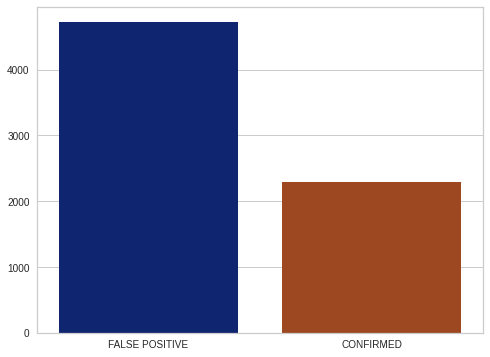

In [66]:
fig, ax = plt.subplots(figsize = (8,6))
with sns.color_palette("dark", 3):
        sns.barplot(subset_df['koi_disposition'].value_counts().index, subset_df['koi_disposition'].value_counts().values)
     


#Data Visualiazation

In [67]:
def getVisualisationPCA(X, y):
    x = StandardScaler().fit_transform(X)
    pca = PCA(n_components=2)
    principal_components = pca.fit_transform(x)
    
    pca_df = pd.DataFrame(
        data = principal_components,
        columns = ['principal component 1', 'principal component 2']
    )
    plt.figure(figsize=(12,8))
    pca_df["TARGET"] = y
    labels = np.unique(y)
    labels = ["CONFIRMED" if i ==1 else "FALSE POSITIVE" for i in labels]
    pca_df["TARGET"] = ["CONFIRMED" if i ==1 else "FALSE POSITIVE" for i in pca_df["TARGET"].values]
    plt.grid()
    colors = cm.rainbow(np.linspace(0, 1, len(labels)))
    for label, color in zip(labels, colors):
        indicesToKeep = pca_df['TARGET'] == label
        plt.scatter(
            pca_df.loc[indicesToKeep, 'principal component 1'],
            pca_df.loc[indicesToKeep, 'principal component 2'],
            c = color,
            label=label
        )
        
    plt.legend()
    plt.grid()
    plt.savefig("pca.png", dpi=600)
    
def getVarianceContribution(X, y):
    cols = X.shape[1]
    x = StandardScaler().fit_transform(X)
    pca = PCA().fit(x)
    variance = pca.explained_variance_ratio_
    s = np.sum(variance)
    p = variance/s
    plt.grid()
    plt.bar(list(range(1, cols+1)), p)
    plt.xlabel('number of components')
    plt.ylabel('cumulative explained variance')
    plt.savefig("variance.png", dpi=600)
    plt.show()
    
    
def getFeatureCorrelation(X, y):
    visualizer = FeatureCorrelation(labels=usable)
    visualizer.fit(X, y)
    visualizer.show("correlation.png", dpi=600)
    
    
def getPearsonRanking(X):
    visualizer = rank2d(X, features=usable)
    visualizer = Rank2D(algorithm='pearson', features=usable)
    visualizer.fit(X, y)           
    visualizer.transform(X)        
    visualizer.show(outpath="pearson_ranking.png", dpi=600)
    

def getRadialViz(X, y):
    visualizer = RadViz(classes=[0, 1], features = usable)
    visualizer.fit(X, y)           
    visualizer.transform(X)        
    visualizer.show("radial.png", dpi=600)

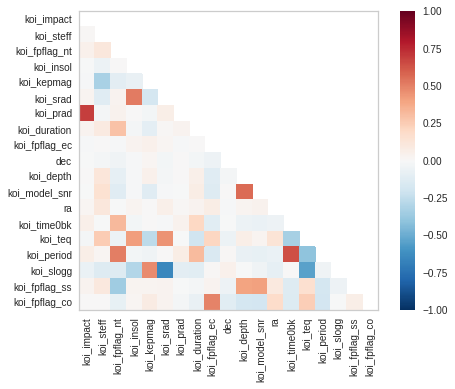

In [18]:
getPearsonRanking(X)

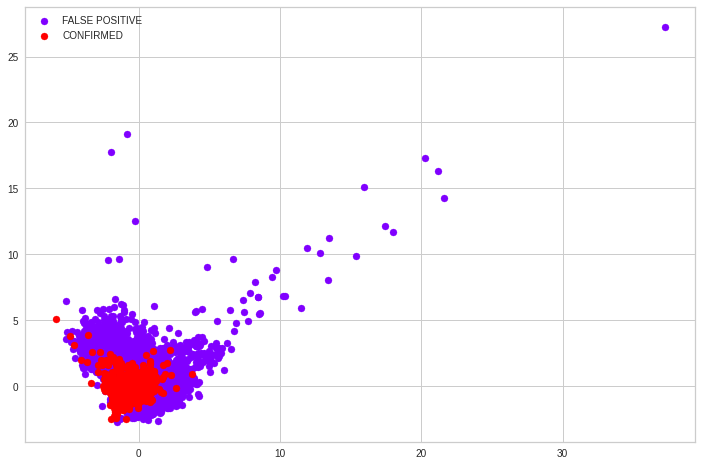

In [24]:
getVisualisationPCA(X, y)

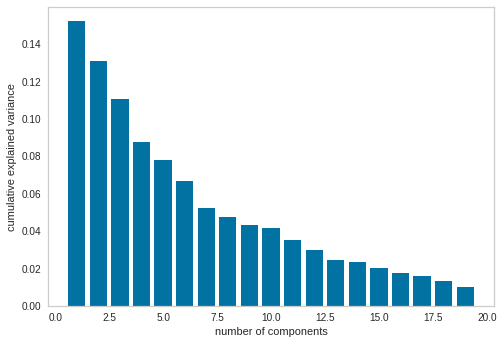

In [25]:
getVarianceContribution(X, y)

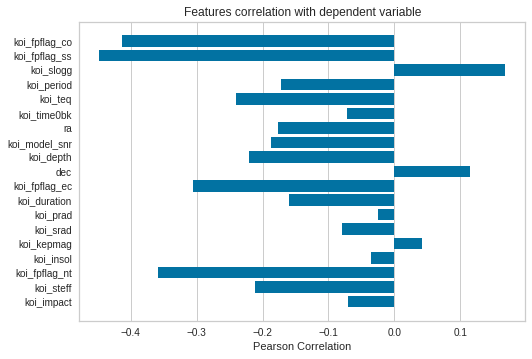

In [26]:
getFeatureCorrelation(X, y)

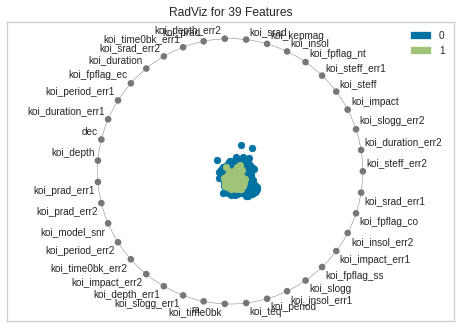

In [74]:
getRadialViz(X, y)



*   We can see that our columns are not interdependent and we can use all our columns
*   We observe that the two classes are not linearly separable, hence a simple Logistic Regression classifier will not do well.


*   Most important, we see there is a class imbalance present, hence we cannot go on accuracy scores and will need to compare scores for prediction across both classes - F1 scores and balanced accuracy scores

We need to hence using different techniques of non-linear classification, which can handle the non-linearity issue as well as class imbalance. We can employ Bagging or Boosting Techniques such as


*  SVM
*  Random Forests
* XgBoost







In [27]:
X = StandardScaler().fit_transform(X)

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

In [29]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((5611, 19), (1403, 19), (5611,), (1403,))

Evaluation Metric
Since the dataset is imbalanced, we cannot use accuracy, hence we opt for the following -

1. Confusion Matrix
2. F1 Score
3. Balanced Accuracy Score

In [30]:
def performance(test, pred):
    conf_matrix = confusion_matrix(test, pred)
    f1 = f1_score(test, pred)
    report = classification_report(test, pred)
    accuracy = balanced_accuracy_score(test, pred)
    print(f"F1 Score: {f1}")
    print(f"Accuracy Score: {accuracy}")
    print(f"Confusion Matrix:\n{conf_matrix}")
    print(report)

##CV Score

In [33]:
def crossValidationCheck(classifier, X, y, K=10):

    cv = KFold(n_splits=K, random_state=1, shuffle=True)
    scores = cross_val_score(classifier, X, y, scoring='f1', cv=cv, n_jobs=-1)
    print(f"Average F1 score over {K}-Folds: {scores.mean()}")
    
    visualizer = CVScores(classifier, cv=cv, scoring='f1')
    visualizer.fit(X, y)
    visualizer.show(f"{str(classifier)[:5]}_cv.png", dpi=600)
    
    visualizer = LearningCurve(classifier, cv=cv, scoring='f1', n_jobs=-1)
    visualizer.fit(X, y)
    
    cv = StratifiedKFold(n_splits=K, random_state=1, shuffle=True)
    scores = cross_val_score(classifier, X, y, scoring='f1', cv=cv, n_jobs=-1)
    print(f"Average F1 score over Stratified {K}-Folds: {scores.mean()}")
    
    visualizer = CVScores(classifier, cv=cv, scoring='f1')
    visualizer.fit(X, y)
    
    visualizer = LearningCurve(classifier, cv=cv, scoring='f1', n_jobs=-1)
    visualizer.fit(X, y)

##Feature Importance

In [31]:
def getFeatureImportance(model, X, y):
    viz = FeatureImportances(model, labels=usable)
    viz.fit(X, y)
    viz.show(f"{model}_imp.png", dpi=600)

##Class Predictions

In [32]:
def getClassPredictionError(classifier):
    visualizer = ClassPredictionError(classifier, classes=[0, 1])
    visualizer.fit(X_train, y_train)
    visualizer.score(X_test, y_test)
    
def getClassificationReport(classifier):
    visualizer = ClassificationReport(classifier, classes=[0, 1])
    visualizer.fit(X_train, y_train)
    visualizer.score(X_test, y_test)
    
def getDiscriminationThreshold(classifier):
    visualizer = DiscriminationThreshold(classifier, exclude=["queue_rate"])
    visualizer.fit(X, y)        
    
def getPrecisionRecall(classifier):
    visualizer = PrecisionRecallCurve(classifier)
    visualizer.fit(X_train, y_train)
    visualizer.score(X_test, y_test)
    
def rocCurve(classifier):
    visualizer = ROCAUC(classifier, classes=[0, 1])
    visualizer.fit(X_train, y_train)
    visualizer.score(X_test, y_test)

In [39]:
import os
import seaborn as sns

In [43]:
def plot_confusion_matrix(predictions, model):
  cm = confusion_matrix(predictions, y_test)
  ax = plt.figure(figsize=(12,8))
  path = '/content/drive/MyDrive/Kepler Exoplanet'
  title = "Confusion Matrix For "  + model + '.png'
  titleCM = "Confusion Matrix For "  + model
  pathmain = os.path.join(path, title)
  group_names = ['True Neg','False Pos','False Neg','True Pos']
  group_counts = ['{0:0.0f}'.format(value) for value in
                  cm.flatten()]
  group_percentages = ['{0:.2%}'.format(value) for value in
                      cm.flatten()/np.sum(cm)]

  labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
            zip(group_names,group_counts,group_percentages)]
  labels = np.asarray(labels).reshape(2,2)
  ax = sns.heatmap(cm ,annot = labels, fmt = '',cmap = 'Blues')
  ax.set_title(titleCM, fontdict = {'weight' : 'bold', 'size' : '16'})
  # classification report
  ax.figure.savefig(pathmain)

In [34]:
def saveModel(model, filename):
    joblib.dump(model, filename)

def loadModel(filename):
    model = joblib.load(filename)
    return model

#SVM with Hyperparamter

In [76]:
parameters = {
    "C":np.arange(1, 3.05, 0.05),
    "gamma":["scale", "auto"],
    "shrinking":[True, False],
    "tol":[1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3],
    "class_weight":[None, "balanced"]
}

scores = ["f1", "balanced_accuracy"]

In [78]:
classifier = GridSearchCV(
    SVC(kernel="rbf", random_state=0),
    parameters,
    scoring=scores,
    refit="f1",
    verbose=1,
    n_jobs=-1
)

classifier.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(estimator=SVC(random_state=0), n_jobs=-1,
                   param_distributions={'C': array([1.  , 1.05, 1.1 , 1.15, 1.2 , 1.25, 1.3 , 1.35, 1.4 , 1.45, 1.5 ,
       1.55, 1.6 , 1.65, 1.7 , 1.75, 1.8 , 1.85, 1.9 , 1.95, 2.  , 2.05,
       2.1 , 2.15, 2.2 , 2.25, 2.3 , 2.35, 2.4 , 2.45, 2.5 , 2.55, 2.6 ,
       2.65, 2.7 , 2.75, 2.8 , 2.85, 2.9 , 2.95, 3.  ]),
                                        'class_weight': [None, 'balanced'],
                                        'gamma': ['scale', 'auto'],
                                        'shrinking': [True, False],
                                        'tol': [0.001, 0.01, 0.1, 1, 10.0,
                                                100.0, 1000.0]},
                   refit='f1', scoring=['f1', 'balanced_accuracy'], verbose=1)

In [79]:
classifier.best_score_

0.9761961572925439

In [80]:
classifier.best_params_

{'tol': 0.001,
 'shrinking': False,
 'gamma': 'auto',
 'class_weight': None,
 'C': 2.9000000000000017}

In [81]:
performance(y_test, classifier.best_estimator_.predict(X_test))

F1 Score: 0.9824561403508771
Accuracy Score: 0.9859083662577113
Confusion Matrix:
[[939   6]
 [ 10 448]]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       945
           1       0.99      0.98      0.98       458

    accuracy                           0.99      1403
   macro avg       0.99      0.99      0.99      1403
weighted avg       0.99      0.99      0.99      1403



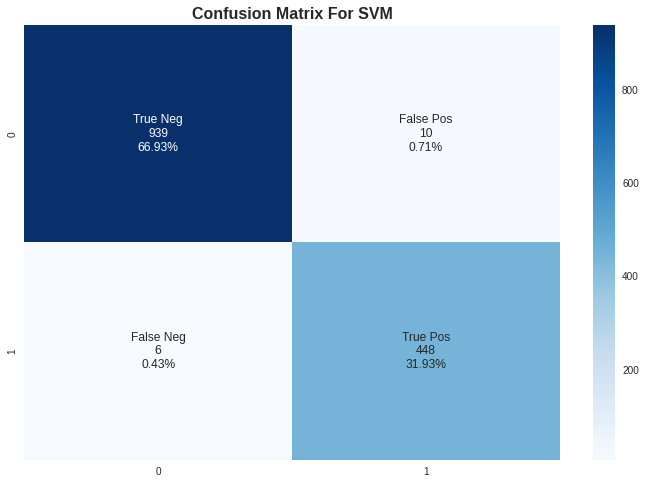

In [82]:
plot_confusion_matrix(classifier.best_estimator_.predict(X_test), "SVM")

In [83]:
crossValidationCheck(classifier.best_estimator_, X, y, K=10)

Average F1 score over 10-Folds: 0.0
Average F1 score over Stratified 10-Folds: 0.0


KeyboardInterrupt: ignored

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7f9757004160> (for post_execute):


KeyboardInterrupt: ignored

Error in callback <function flush_figures at 0x7f9756da4d30> (for post_execute):


KeyboardInterrupt: ignored

In [85]:
saveModel(classifier.best_estimator_, "/content/drive/MyDrive/Kepler Exoplanet/model/svm-error.model")

#Random Forest

In [86]:
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]
parameters = {'n_estimators': n_estimators,
                  'max_features': max_features,
                  'max_depth': max_depth,
                  'min_samples_split': min_samples_split,
                  'min_samples_leaf': min_samples_leaf,
                  'bootstrap': bootstrap}   

scores = ["f1", "balanced_accuracy"]

In [87]:
# with GridSearch
gs_rf = RandomizedSearchCV(RandomForestClassifier(random_state=42), parameters, scoring=scores, cv=5,  refit="f1",
    verbose=1,
    n_jobs=-1)

# We train the model
gs_rf.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   refit='f1', scoring=['f1', 'balanced_accuracy'], verbose=1)

In [88]:
gs_rf.best_score_

0.9803511525163827

In [89]:
gs_rf.best_params_

{'n_estimators': 1400,
 'min_samples_split': 2,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': 50,
 'bootstrap': True}

Average F1 score over 10-Folds: 0.9767762135292019
Average F1 score over Stratified 10-Folds: 0.9770075404788952


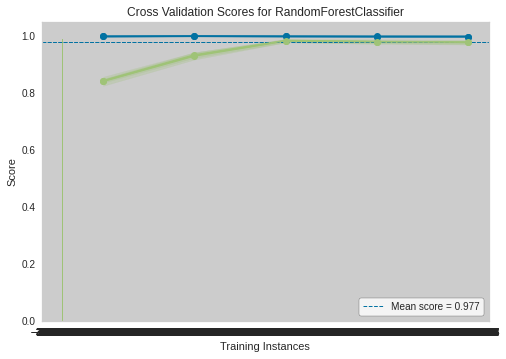

In [90]:
crossValidationCheck(gs_rf.best_estimator_, X, y, K=10)

###Feature Importance

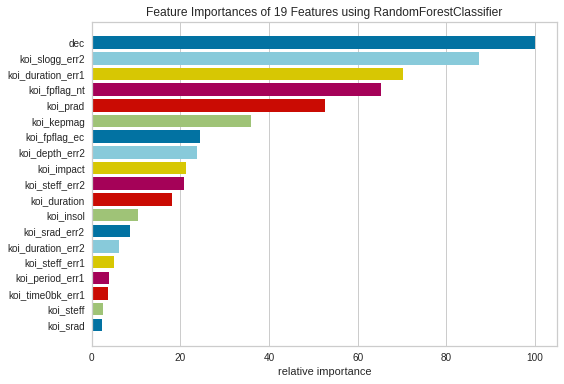

In [94]:
getFeatureImportance(gs_rf.best_estimator_, X, y)

In [96]:
pred = gs_rf.best_estimator_.predict(X_test)

###Performance

In [98]:
performance(y_test, pred)

F1 Score: 0.9778270509977827
Accuracy Score: 0.9798537464476329
Confusion Matrix:
[[942   3]
 [ 17 441]]
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       945
           1       0.99      0.96      0.98       458

    accuracy                           0.99      1403
   macro avg       0.99      0.98      0.98      1403
weighted avg       0.99      0.99      0.99      1403



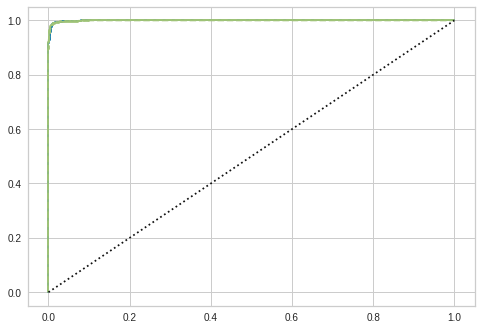

In [99]:
rocCurve(gs_rf.best_estimator_)

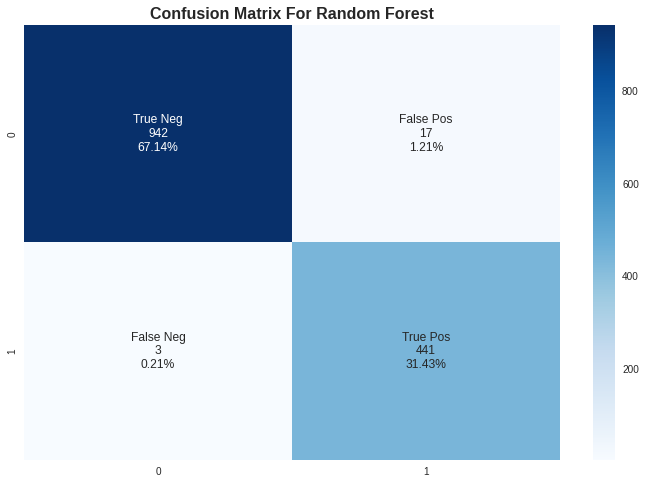

In [100]:
plot_confusion_matrix(pred, "Random Forest")

#XGBoost

In [122]:
parameters_xg = {
    "n_estimators":np.arange(50,150,10),
    "learning_rate":np.arange(0.5,1.5,0.05),
    "algorithm":["SAMME", "SAMME.R"],
    "base_estimator":[
        DecisionTreeClassifier(max_depth=1),
        DecisionTreeClassifier(max_depth=2),
        DecisionTreeClassifier(max_depth=3),
        DecisionTreeClassifier(max_depth=None)
    ]
}

scores = ["f1", "balanced_accuracy"]

In [123]:
classifier_xg = RandomizedSearchCV(
    XGBClassifier(random_state=0),
    parameters_xg,
    scoring=scores,
    refit="f1",
    verbose=1,
    n_jobs=-1
)

classifier_xg.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(estimator=XGBClassifier(), n_jobs=-1,
                   param_distributions={'algorithm': ['SAMME', 'SAMME.R'],
                                        'base_estimator': [DecisionTreeClassifier(max_depth=1),
                                                           DecisionTreeClassifier(max_depth=2),
                                                           DecisionTreeClassifier(max_depth=3),
                                                           DecisionTreeClassifier()],
                                        'learning_rate': array([0.5 , 0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ,
       1.05, 1.1 , 1.15, 1.2 , 1.25, 1.3 , 1.35, 1.4 , 1.45]),
                                        'n_estimators': array([ 50,  60,  70,  80,  90, 100, 110, 120, 130, 140])},
                   refit='f1', scoring=['f1', 'balanced_accuracy'], verbose=1)

In [124]:
classifier_xg.best_score_

0.9818797512262046

In [125]:
classifier_xg.best_params_

{'n_estimators': 60,
 'learning_rate': 0.5,
 'base_estimator': DecisionTreeClassifier(max_depth=1),
 'algorithm': 'SAMME.R'}

Average F1 score over 10-Folds: 0.9853733170092134
Average F1 score over Stratified 10-Folds: 0.9864010108931712


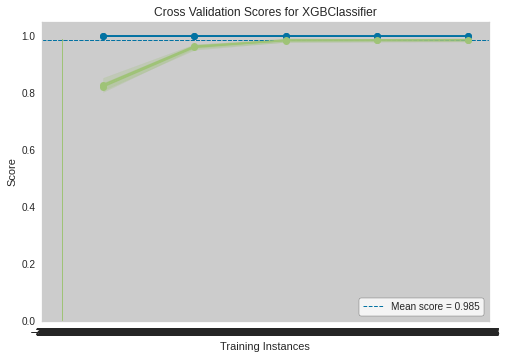

In [126]:
crossValidationCheck(classifier_xg.best_estimator_, X, y, K=10)

In [127]:
performance(y_test, classifier_xg.best_estimator_.predict(X_test))

F1 Score: 0.9857923497267759
Accuracy Score: 0.9891834754280169
Confusion Matrix:
[[939   6]
 [  7 451]]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       945
           1       0.99      0.98      0.99       458

    accuracy                           0.99      1403
   macro avg       0.99      0.99      0.99      1403
weighted avg       0.99      0.99      0.99      1403



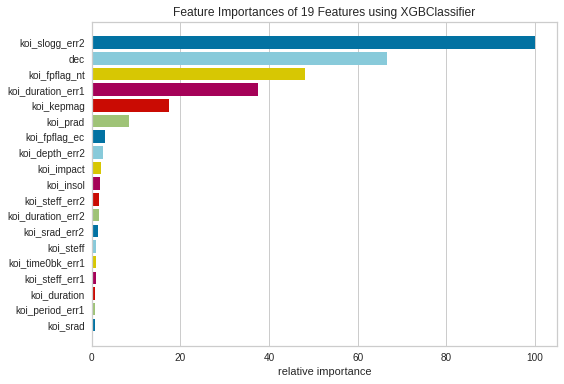

In [128]:
getFeatureImportance(classifier_xg.best_estimator_, X, y)

In [129]:
pred = classifier_xg.best_estimator_.predict(X_test)

In [130]:
performance(y_test, pred)

F1 Score: 0.9857923497267759
Accuracy Score: 0.9891834754280169
Confusion Matrix:
[[939   6]
 [  7 451]]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       945
           1       0.99      0.98      0.99       458

    accuracy                           0.99      1403
   macro avg       0.99      0.99      0.99      1403
weighted avg       0.99      0.99      0.99      1403



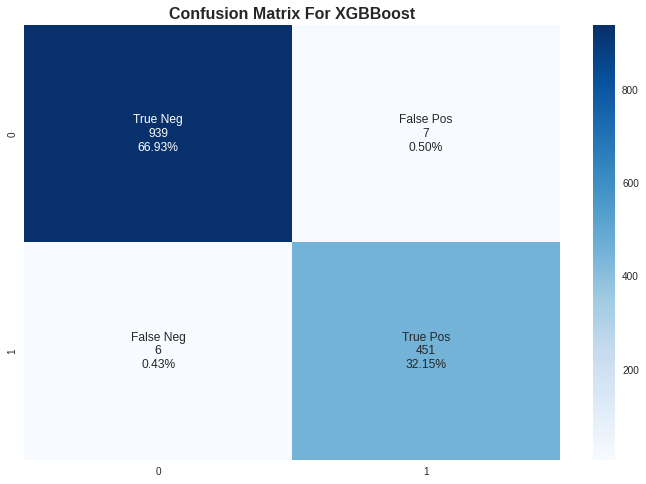

In [131]:
plot_confusion_matrix(pred, "XGBBoost")

In [132]:
saveModel(classifier.best_estimator_, "/content/drive/MyDrive/Kepler Exoplanet/model/XGboost-error.model")

# Clustering